In [149]:
!pip install --upgrade PyDOE

Requirement already up-to-date: PyDOE in /usr/local/lib/python3.7/dist-packages (0.3.8)


In [150]:
import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

onp.random.seed(1234)

In [151]:
# A vectorized RBF kernel function
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [152]:
# A wrapper to call SciPy's L-BFGS-B optimizer
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [153]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF): 
        self.kernel = kernel_fn
                              
    def random_init_GP(self, rng_key, dim):
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))
        hyp = np.concatenate([logsigma_f, loglength, logsigma_n])
        return hyp

    def likelihood(self, params, batch):
        X, y = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute Cholesky
        K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)
        L = cholesky(K, lower=True)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        X, _ = batch
        dim = X.shape[1]
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X, y = batch
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)
        L = cholesky(K, lower=True)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean, std
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))[:,None]
        return mu, std      

In [154]:
def f(x):
  return x*np.sin(8.0*np.pi*x)

In [155]:
N = 15
dim = 1
noise = 0.0
lb = np.array([0.0])
ub = np.array([1.0])

# Training data
X = lb + (ub-lb)*lhs(dim, N)
y = vmap(f)(X)
y = y + noise*y.std(0)*onp.random.randn(N,1)

# Test data
n_star = 1000
X_star = np.linspace(lb[0], ub[0], n_star)[:,None]
y_star = vmap(f)(X_star)

In [156]:
model = GPRegression(kernel_fn = RBF)

In [157]:
# Normalize training data
mu_y, sigma_y = y.mean(0), y.std(0)
X_train = (X - lb)/(ub-lb)
y_train = (y - mu_y)/sigma_y

# Train model
train_key = random.PRNGKey(0)
opt_params = model.train((X_train, y_train), train_key, num_restarts = 10)

100%|██████████| 10/10 [00:00<00:00, 14.24it/s]


In [158]:
# Normalize test inputs
X_test = (X_star - lb)/(ub-lb)

# Make predictions
mean, std = model.predict(opt_params, (X_train, y_train), X_test)

# De-normalize predictions
mean, std = mean*sigma_y + mu_y, std*sigma_y

# Uncertainty bands
lower = mean - 2.0*std
upper = mean + 2.0*std

# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 1.167585e-01


Text(0, 0.5, '$f(x)$')

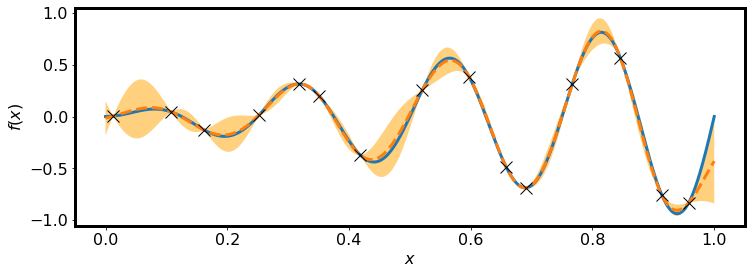

In [159]:
# Plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (12,4))
plt.plot(X_star, y_star, lw = 3)
plt.plot(X_star, mean, '--', lw = 3)
plt.plot(X, y, 'kx', ms = 12)
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                  facecolor='orange', alpha=0.5, label="Two std band")
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')